<h1>DATA PREPROCESSING</h1>

<h2>Importing Dataset</h2>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

In [23]:
df=pd.read_csv("Tweets.csv")
df2=pd.read_csv("twitter_training.csv")
df2

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [24]:
df2.columns = ['#', 'refers to', 'sentiment', 'text']
df2

,#,refers to,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [25]:
df2=df2[["text","sentiment"]]
df2

,text,sentiment
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive
...,...,...
74676,Just realized that the Windows partition of my...,Positive
74677,Just realized that my Mac window partition is ...,Positive
74678,Just realized the windows partition of my Mac ...,Positive
74679,Just realized between the windows partition of...,Positive


In [26]:
df2=df2.loc[df2.sentiment!="Irrelevant"]
df2

,text,sentiment
0,I am coming to the borders and I will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive
...,...,...
74676,Just realized that the Windows partition of my...,Positive
74677,Just realized that my Mac window partition is ...,Positive
74678,Just realized the windows partition of my Mac ...,Positive
74679,Just realized between the windows partition of...,Positive


In [27]:
df2.dropna(inplace=True,axis=0)

C:\Users\ganes\AppData\Local\Temp\ipykernel_27316\600528996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(inplace=True,axis=0)


In [28]:
df=df[["text","sentiment"]]
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [29]:
df.dropna(inplace=True,axis=0)

In [30]:
df.shape

(27480, 2)

In [31]:
df2.shape

(61120, 2)

In [32]:
df.info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61120 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       61120 non-null  object
 1   sentiment  61120 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [33]:
final_dataset=pd.concat([df,df2])
final_dataset

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
74676,Just realized that the Windows partition of my...,Positive
74677,Just realized that my Mac window partition is ...,Positive
74678,Just realized the windows partition of my Mac ...,Positive
74679,Just realized between the windows partition of...,Positive


In [34]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88600 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       88600 non-null  object
 1   sentiment  88600 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [35]:
final_dataset.loc[final_dataset["sentiment"]=="Positive"]="positive"
final_dataset.loc[final_dataset["sentiment"]=="Negative"]="negative"
final_dataset.loc[final_dataset["sentiment"]=="Neutral"]="neutral"


In [36]:
import nltk
import re
from nltk.corpus import stopwords

sw_list=stopwords.words('english')
word_count={
    "positive":[],
    "negative":[],
    "neutral":[]
}

pattern=re.compile("[^\w ]")

for text,target in zip(df.text,df.sentiment):
    text=re.sub(pattern,"",text).lower().split()
    text=[word for word in text if word not in sw_list]
    word_count[target].extend(text)

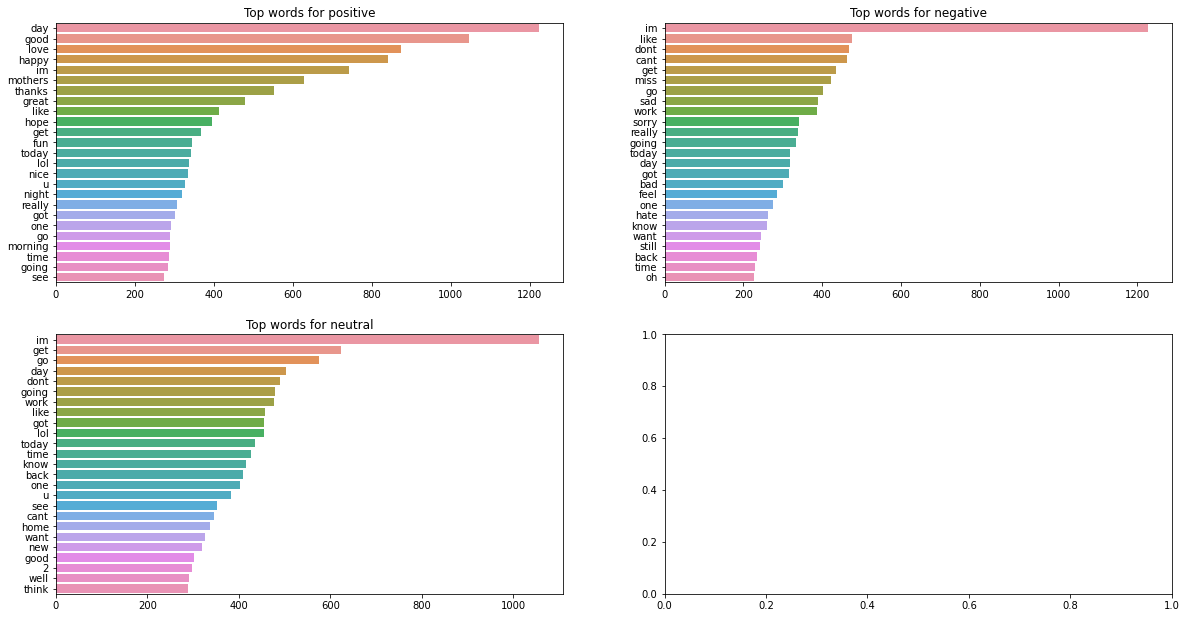

In [37]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_count.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(sublinear_tf=True,min_df=5,ngram_range=(1,2),stop_words="english",max_features=10000)

features=tfidf.fit_transform(final_dataset["text"]).toarray()
labels=final_dataset["sentiment"]


In [50]:
# emoticon
import regex as re
import emoji

def split_count(text):
    emoji_list=[]
    for word in text:
        emojis=emoji.distinct_emoji_list(text)
        emoji_list.append(emoji.demojize(is_emoji) for is_emoji in emojis)
    
    return emoji_list
    


In [51]:
texts=final_dataset.text

In [52]:
target_emoji={
    "positive":[],
    "negative":[],
    "neutral":[]
}

for text,target in zip(final_dataset.text,final_dataset.sentiment):
    emoji_count=split_count(text)
    if split_count:
        target_emoji[target].append(emoji_count)